# 用逻辑回归制作评分卡

数据：rankingcard

模型：LR

算法：LogisticRegression

# 学习目标：

熟悉银行制作评分卡的步骤和流程

了解LR模型的基本原理

掌握RandomForestRegressor算法的基本原理和使用方法

根据WOE和IV指标进行特征选择，以制定相应的评分标准

# 任务描述：

借助银行客户数据，对客户特征进行分箱。

对不同的客户类别进行特征分析，比较不同类别客户的违约概率。

# 获取数据

In [1]:
#导库，获取数据
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR

In [2]:
data = pd.read_csv('rankingcard.csv',index_col=0)

In [3]:
#探索数据
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
data.shape

(150000, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

# 数据预处理

In [4]:
#去掉重复值
data.drop_duplicates(inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149391 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

In [5]:
#更新索引
data.index = range(data.shape[0])

In [104]:
#查看缺失值
data.isnull().mean()

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [6]:
#填补NumberOfDependents缺失值
data['NumberOfDependents'].fillna(int(data['NumberOfDependents'].mean()),inplace=True)

In [7]:
#使用随机森林填补MonthlyIncome的缺失值
def fill_missing_rfr(x,y,to_fill):
    """
    参数：
    x：要填补的特征矩阵
    y：完整的，没有缺失值的标签
    to_fill：字符串，要填补的那一列名称
    """
    #构建我们的新特征矩阵和标签
    df = x.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns!=to_fill],pd.DataFrame(y)],axis=1)
    
    #找出我们的训练集和测试集
    ytrain = fill[fill.notnull()]
    ytest = fill[fill.isnull()]
    xtrain = df.iloc[ytrain.index,:]
    xtest = df.iloc[ytest.index,:]
    
    #用随机森林填补缺失值
    from sklearn.ensemble import RandomForestRegressor as RFR
    rfr = RFR(n_estimators=100)
    rfr = rfr.fit(xtrain,ytrain)
    ypredict = rfr.predict(xtest)
    
    return ypredict

In [8]:
#将参数导入函数
x = data.iloc[:,1:]
y = data['SeriousDlqin2yrs']

In [9]:
y_pred = fill_missing_rfr(x,y,'MonthlyIncome')

In [10]:
#把数据填补到原数据集中
data.loc[data.loc[:,'MonthlyIncome'].isnull(),'MonthlyIncome'] = y_pred

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         149391 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtype

In [39]:
#查看异常值
data.describe([0.01,0.1,0.25,.5,.75,.9,.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,145831.0,0.059212,0.236023,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
RevolvingUtilizationOfUnsecuredLines,145831.0,0.301930,0.335974,0.0,0.0,0.002876,0.028762,0.143877,0.514950,0.928845,1.0,1.0
age,145831.0,52.514959,14.696239,21.0,24.0,33.000000,42.000000,52.000000,63.000000,72.000000,87.0,99.0
NumberOfTime30-59DaysPastDueNotWorse,145831.0,0.229204,0.666371,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.0,13.0
DebtRatio,145831.0,357.459492,2061.619765,0.0,0.0,0.035387,0.178175,0.368527,0.879231,1294.000000,4999.0,329664.0
MonthlyIncome,145831.0,5451.126866,13374.233453,0.0,0.0,0.180000,1800.000000,4481.000000,7488.000000,10833.000000,23333.0,3008750.0
NumberOfOpenCreditLinesAndLoans,145831.0,8.542121,5.141987,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,25.0,58.0
NumberOfTimes90DaysLate,145831.0,0.078276,0.441593,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,17.0
NumberRealEstateLoansOrLines,145831.0,1.031777,1.132487,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,5.0,54.0
NumberOfTime60-89DaysPastDueNotWorse,145831.0,0.056709,0.303594,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,11.0


In [12]:
#RevolvingUtilizationOfUnsecuredLines(贷款以及信用卡可用额度与总额度比例)该指标应该为小于1的数
#故有1%左右的数应该删掉
data = data[data['RevolvingUtilizationOfUnsecuredLines']<=1]

In [13]:
#age的最小年龄为0，最大年龄为109，明显不符合银行的业务需求，故删除
data = data[data['age']<100]

In [14]:
data = data[data['age']!=0]

In [118]:
#DebtRatio和MonthlyIncome都存在较高的值，这是可能存在的，我们不删除
#NumberOfTime30-59DaysPastDueNotWorse和NumberOfTimes90DaysLate，NumberOfTime60-89DaysPastDueNotWorse
#这3个指标都有一个最大值98次，我们来查看一下有多少个样本存在这种异常
data[data.loc[:,'NumberOfTime30-59DaysPastDueNotWorse']>90].count()

SeriousDlqin2yrs                        225
RevolvingUtilizationOfUnsecuredLines    225
age                                     225
NumberOfTime30-59DaysPastDueNotWorse    225
DebtRatio                               225
MonthlyIncome                           225
NumberOfOpenCreditLinesAndLoans         225
NumberOfTimes90DaysLate                 225
NumberRealEstateLoansOrLines            225
NumberOfTime60-89DaysPastDueNotWorse    225
NumberOfDependents                      225
dtype: int64

In [52]:
#有225个样本存在这样的情况，我们来看一下这些样本的标签,标签并不是都为1，因此我们判断这些样本是异常值，应该删掉
data[data.loc[:,'NumberOfTime30-59DaysPastDueNotWorse']>90].groupby(by='SeriousDlqin2yrs').count()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,,,,,,,,,,
0,89,89,89,89,89,89,89,89,89,89
1,136,136,136,136,136,136,136,136,136,136


In [15]:
data = data[data.loc[:,'NumberOfTime30-59DaysPastDueNotWorse']<90]

In [16]:
#恢复索引
data.index = range(data.shape[0])

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145831 entries, 0 to 145830
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      145831 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  145831 non-null  float64
 2   age                                   145831 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  145831 non-null  int64  
 4   DebtRatio                             145831 non-null  float64
 5   MonthlyIncome                         145831 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       145831 non-null  int64  
 7   NumberOfTimes90DaysLate               145831 non-null  int64  
 8   NumberRealEstateLoansOrLines          145831 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  145831 non-null  int64  
 10  NumberOfDependents                    145831 non-null  float64
dtype

In [17]:
#探索标签的分布
x = data.iloc[:,1:]
y = data.iloc[:,0]

In [92]:
y.value_counts()

0    137196
1      8635
Name: SeriousDlqin2yrs, dtype: int64

In [18]:
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x,y = sm.fit_sample(x,y)

In [93]:
n_sample_ = x.shape[0]

n_1_sample = pd.Series(y).value_counts()[1]
n_0_sample = pd.Series(y).value_counts()[0]

print('样本个数: {}; 1占{:.2%};0占{:.2%}'.format(n_sample_,n_1_sample/n_sample_,n_0_sample/n_sample_))

样本个数: 274392; 1占50.00%;0占50.00%


In [19]:
#分训练集和测试集
from sklearn.model_selection import train_test_split
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [125]:
x.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [126]:
y.head()

,SeriousDlqin2yrs
0,1
1,0
2,0
3,0
4,0


In [87]:
X_train,X_vali,Y_train,Y_vali = train_test_split(x,y,test_size=0.3,random_state=42)

In [88]:
model_data = pd.concat([Y_train,X_train],axis=1)
model_data.index = range(model_data.shape[0])
model_data.columns = data.columns

In [89]:
vali_data = pd.concat([Y_vali,X_vali],axis=1)
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns

In [90]:
model_data.to_csv('model_data.csv')
vali_data.to_csv('vali_data.csv')

# 特征分箱

![title](2.png)

![title](1.png)

![title](3.png)

## 卡方检验，合并箱体，画出IV曲线

In [91]:
import matplotlib.pyplot as plt
import scipy

"""
   自动最优分箱函数，基于卡方检验的分箱
   参数：
   DF: 需要输入的数据
   X: 需要分箱的列名
   Y: 分箱数据对应的标签 Y 列名
   n: 保留分箱个数
   q: 初始分箱的个数
   graph: 是否要画出IV图像
   区间为前开后闭 (]
"""
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    DF = DF[[X,Y]].copy()
    #等频分箱
    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    # 统计每个分箱中0和1的数量
    # 这里使用了数据透视表的功能groupby
    count_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    count_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    #bins值分别为每个区间的上界，下界，0出现的次数，1出现的次数
    #注意zip会按照最短列来进行结合
    num_bins = [*zip(bins,bins[1:],count_y0,count_y1)]
    
    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(num_bins[0][0],
                              num_bins[1][1],
                              num_bins[0][2]+num_bins[1][2],
                              num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break

        #计算WOE和BAD RATE
        #BAD RATE与bad%不是一个东西
        #BAD RATE是一个箱中，坏的样本所占的比例 (bad/total)
        #而bad%是一个箱中的坏样本占整个特征中的坏样本的比例
    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0 / df.count_0.sum()
        df["bad%"] = df.count_1 / df.count_1.sum()
        df["woe"] = np.log(df["bad%"] / df["good%"])
        return df

    def get_iv(df):
        rate = df["bad%"] - df["good%"]
        iv = np.sum(rate * df.woe)
        return iv
    
    IV = []
    axisx = []
    bins_df = []
    while len(num_bins) > n:
        pvs = []
        #获取num_bins_两两之间的卡方检验的置信度（或卡方值）
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            #0返回chi2值，1返回p值
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)
        #通过p值进行处理，合并p值最大的两组
        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]
        
        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
       
    if graph:
        plt.figure()
        plt.plot(axisx,IV) 
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show() 
    return bins_df 

In [92]:
#对所有特征进行分箱选择
model_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

RevolvingUtilizationOfUnsecuredLines


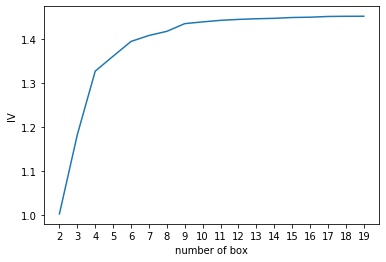

age


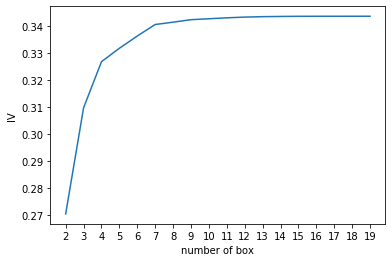

NumberOfTime30-59DaysPastDueNotWorse


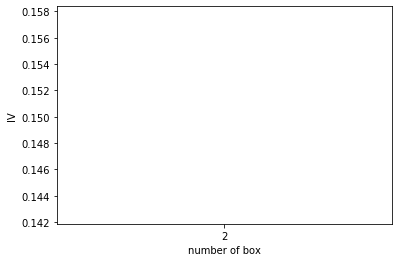

DebtRatio


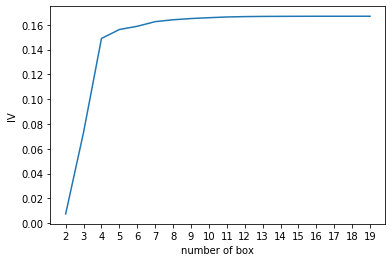

MonthlyIncome


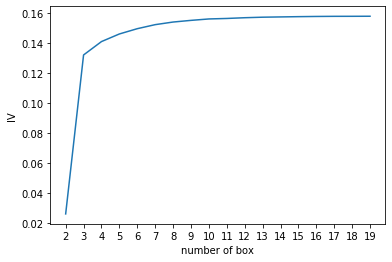

NumberOfOpenCreditLinesAndLoans


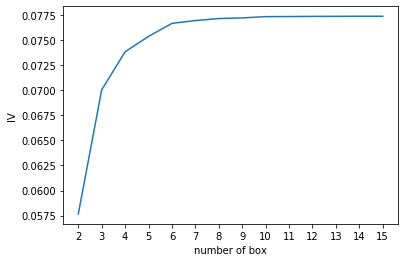

NumberOfTimes90DaysLate


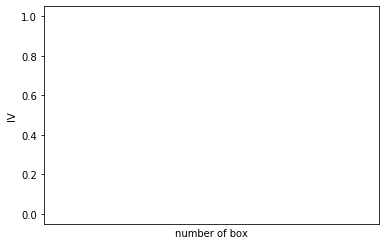

NumberRealEstateLoansOrLines


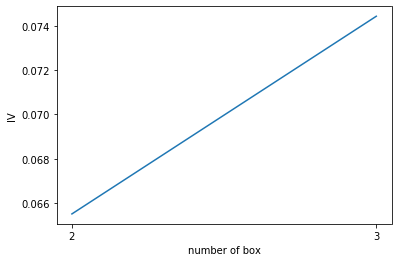

NumberOfTime60-89DaysPastDueNotWorse


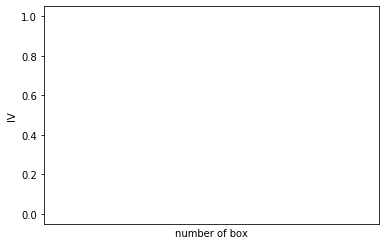

NumberOfDependents


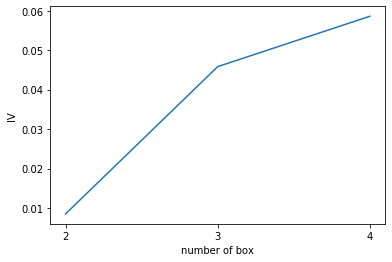

In [93]:
for i in model_data.columns[1:]:
    print(i)
    graphforbestbin(model_data,i,'SeriousDlqin2yrs',n=2,q=20,graph=True)

In [106]:
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":6,
                 "age":5,
                 "DebtRatio":4,
                 "MonthlyIncome":5,
                 "NumberOfOpenCreditLinesAndLoans":5}

#不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
             ,"NumberOfTimes90DaysLate":[0,1,2,17]
             ,"NumberRealEstateLoansOrLines":[0,1,2,4,58]
             ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,11]
             ,"NumberOfDependents":[0,1,2,20]}


hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

In [107]:
#对所有特征按照选择的箱体个数和手写的分箱范围进行分箱：
bins_of_col = {}

#生成自动分箱的分箱区间和分箱后的iv值
for col in auto_col_bins:
    bins_df = graphforbestbin(model_data,col
                              ,'SeriousDlqin2yrs'
                              ,n=auto_col_bins[col]
                              #使用字典的性质来取出每个特征所对应的箱的数量
                              ,q=20
                              ,graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list

In [108]:
#合并手动分箱数据  
bins_of_col.update(hand_bins)

In [109]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.05668519479999999,
  0.1993155003,
  0.34292807220000004,
  0.6547330328309076,
  0.9775536699280374,
  inf],
 'age': [-inf, 34.0, 52.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.016965554972784402,
  0.36398661748326794,
  1.5058361941178164,
  inf],
 'MonthlyIncome': [-inf, 0.1, 0.31, 3388.375873366267, 6233.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

## 计算各箱的WOE并映射到数据中

In [115]:
#data = model_data.copy()

In [116]:
#data = data[["age","SeriousDlqin2yrs"]].copy()

In [117]:
#data.head()

,age,SeriousDlqin2yrs
0,40,1
1,37,1
2,41,0
3,28,1
4,42,1


In [118]:
data["cut"] = pd.cut(data["age"],[-np.inf, 48.49986200790144, 58.757170160044694, 64.0, 
74.0, np.inf])

In [119]:
data

,age,SeriousDlqin2yrs,cut
0,40,1,"(-inf, 48.5]"
1,37,1,"(-inf, 48.5]"
2,41,0,"(-inf, 48.5]"
3,28,1,"(-inf, 48.5]"
4,42,1,"(-inf, 48.5]"
...,...,...,...
192069,56,0,"(48.5, 58.757]"
192070,47,1,"(-inf, 48.5]"
192071,47,0,"(-inf, 48.5]"
192072,55,1,"(48.5, 58.757]"


In [122]:
#data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()

SeriousDlqin2yrs,0,1
cut,,
"(-inf, 48.5]",38636,57076
"(48.5, 58.757]",23102,24760
"(58.757, 64.0]",13571,8169
"(64.0, 74.0]",13326,4337
"(74.0, inf]",7700,1397


In [124]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    #参数为 pd.cut(数据，以列表表示的分箱间隔)
    df["cut"] = pd.cut(df[col],bins)
    #使用groupby透视数据，按区间和0，1统计数据，使用unstack()来将树状结构变成表状结构
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[1]/bins_df[1].sum())/(bins_df[0]/bins_df[0].sum()))
    return woe

In [125]:
#将所有woe存储在字典中
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,'SeriousDlqin2yrs',bins_of_col[col])

In [126]:
woeall

{'RevolvingUtilizationOfUnsecuredLines': cut
 (-inf, 0.0567]    -2.297095
 (0.0567, 0.199]   -0.990526
 (0.199, 0.343]    -0.125917
 (0.343, 0.655]     0.610887
 (0.655, 0.978]     1.339787
 (0.978, inf]       0.666652
 dtype: float64,
 'age': cut
 (-inf, 34.0]    0.524709
 (34.0, 52.0]    0.318328
 (52.0, 61.0]   -0.141062
 (61.0, 74.0]   -0.980764
 (74.0, inf]    -1.700687
 dtype: float64,
 'DebtRatio': cut
 (-inf, 0.017]    -1.479903
 (0.017, 0.364]   -0.078005
 (0.364, 1.506]    0.370888
 (1.506, inf]     -0.172690
 dtype: float64,
 'MonthlyIncome': cut
 (-inf, 0.1]          -1.412284
 (0.1, 0.31]          -0.194797
 (0.31, 3388.376]      0.334938
 (3388.376, 6233.0]    0.150907
 (6233.0, inf]        -0.248203
 dtype: float64,
 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 1.0]    0.903947
 (1.0, 3.0]     0.340948
 (3.0, 5.0]    -0.008615
 (5.0, 17.0]   -0.118012
 (17.0, inf]   -0.385382
 dtype: float64,
 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 0.0]   -0.305905
 (0.0, 

In [127]:
#把所有WOE映射到原始数据中
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据model_data一模一样
model_woe = pd.DataFrame(index=model_data.index)

In [128]:
#将原数据分箱后，按箱的结果把WOE结构用map函数映射到数据中
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])

In [129]:
#将标签补充到数据中
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]

In [130]:
#这就是我们的建模数据了
model_woe.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.990526,0.318328,0.370888,-0.248203,-0.118012,-0.305905,-0.211441,-0.164306,-0.104692,0.509888,1
1,1.339787,0.318328,-0.078005,0.150907,-0.118012,-0.305905,-0.211441,-0.164306,-0.104692,0.487446,1
2,-2.297095,0.318328,-0.078005,-0.248203,0.340948,-0.305905,-0.211441,-0.164306,-0.104692,-0.631218,0
3,0.666652,0.524709,-0.078005,0.334938,0.903947,-0.305905,-0.211441,0.367652,-0.104692,0.605156,1
4,0.610887,0.318328,-0.172690,0.334938,-0.118012,-0.305905,-0.211441,-0.164306,-0.104692,0.605156,1


# 建模与模型验证

In [131]:
#处理测试集
vali_woe = pd.DataFrame(index=vali_data.index)

In [132]:
for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]

In [133]:
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]

In [134]:
#可以开始顺利建模了：
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]

In [135]:
from sklearn.linear_model import LogisticRegression as LR

lr = LR().fit(X,y)
lr.score(vali_X,vali_y)

0.7756505260088924

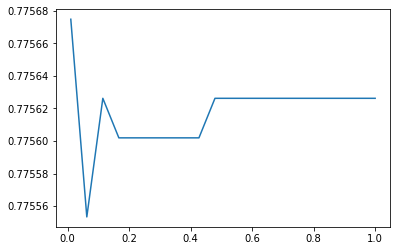

In [136]:
#返回的结果一般，我们可以试着使用C和max_iter的学习曲线把逻辑回归的效果调上去
c_1 = np.linspace(0.01,1,20)

score = []
for i in c_1: 
    lr = LR(solver='liblinear',C=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_1,score)
plt.show()

In [137]:
lr.n_iter_

array([5], dtype=int32)

D:\develop\python\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\develop\python\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\develop\python\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\develop\python\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\develop\python\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the numb

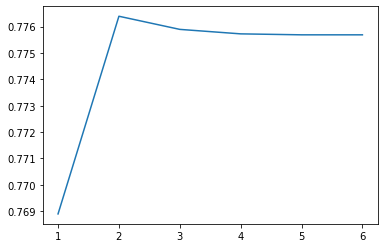

In [139]:
score = []
for i in [1,2,3,4,5,6]: 
    lr = LR(solver='liblinear',C=0.015,max_iter=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot([1,2,3,4,5,6],score)
plt.show()

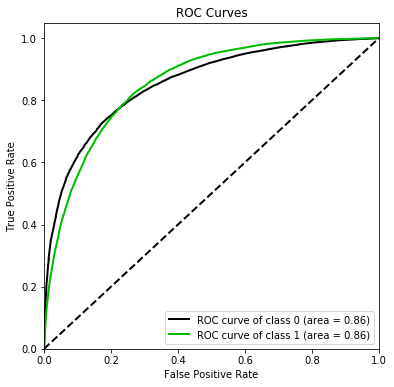

In [142]:
#尽管从准确率来看，我们的模型效果属于一般，但我们可以来看看ROC曲线上的结果。
import scikitplot as skplt

vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))
skplt.metrics.plot_roc(vali_y, vali_proba_df
                       ,plot_micro=False
                       ,figsize=(6,6)
                       ,plot_macro=False)

# 制作评分卡

In [143]:
B = 20/np.log(2)
A = 600 + B*np.log(1/60)

In [144]:
base_score = A - B*lr.intercept_

In [145]:
score_age = woeall["age"] * (-B*lr.coef_[0][0])

In [146]:
file = "ScoreData.csv"
with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i,col in enumerate(X.columns):
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")